In [1]:
polish_dictionary = {}
with open("morfologik.txt") as f:
    for line in f.readlines():
        base_word, flex_form, meta = line.split(";")
        polish_dictionary[flex_form.lower()] = base_word
        
print(len(polish_dictionary))

4623718


In [2]:
import regex
word_pattern = "\p{Letter}{2,}"

In [3]:
FILE_LIST = "files.pickle"
DATA_DIR = "/run/media/maciej/Nowy/data/json/"
CHOSEN_YEAR = "2011"

In [4]:
import os, json

import pickle
from tqdm import tqdm
from collections import defaultdict

words_with_counts = defaultdict(lambda: 0)

def load_data():    
    files = pickle.load(open(FILE_LIST, 'rb'))
    for file in tqdm(files):
        if file.startswith("judgment"):
            file_path = os.path.join(DATA_DIR, file)

            with open(file_path, 'r') as f:
                data = json.load(f)
                judgments = [x["textContent"] for x in data["items"] if x["judgmentDate"].startswith(CHOSEN_YEAR)]

            for judgment in judgments:
                judgment = regex.sub("<.*?>", "", judgment)
                
                for match in regex.finditer(word_pattern, judgment):
                    [word] = match.captures()
                    words_with_counts[word.lower()] += 1
load_data()
print(len(words_with_counts))


100%|██████████| 68/68 [00:12<00:00,  5.30it/s]

139256


In [5]:
polish_words = {}
not_recognized = {}

for word, counts in words_with_counts.items():
    if word in polish_dictionary:
        polish_words[word] = counts
    else:
        not_recognized[word] = counts
        
print("{} words were recognized.".format(len(polish_words))) 
print("{} were not present in the dictionary.".format(len(not_recognized)))

114216 words were recognized.
25040 were not present in the dictionary.


In [6]:
def sort_by_frequency(words, top=None):
    sorted_items = sorted(words.items(), key=lambda x: x[1], reverse=True) 
    if top:
        return sorted_items[:top]
    else:
        return sorted_items

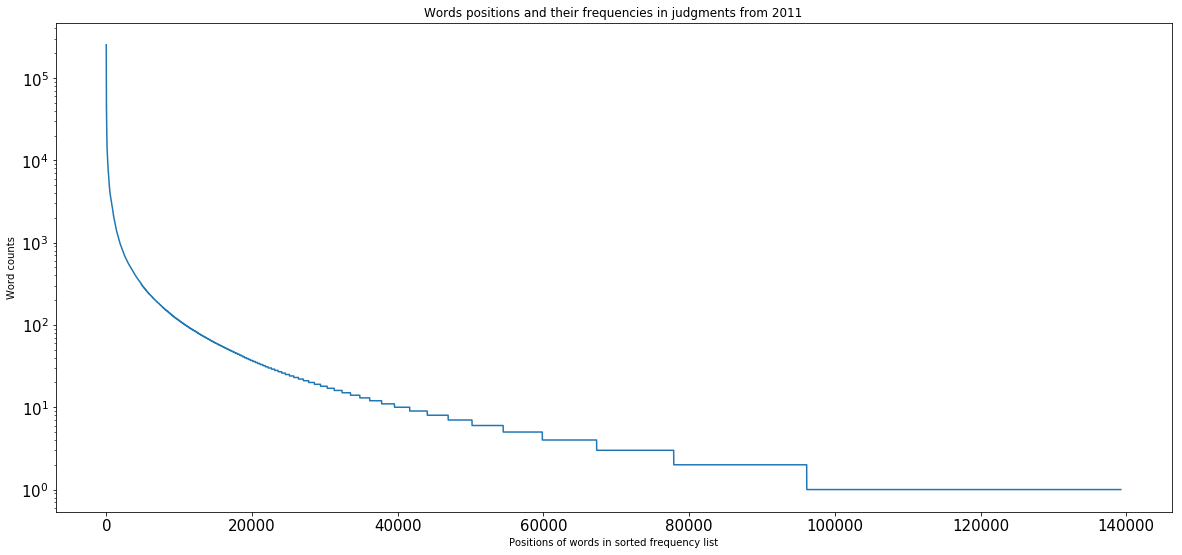

In [15]:
import matplotlib.pyplot as plt

def sort_and_enumerate(words):
    sorted_word_counts = sort_by_frequency(words)
    _words, word_counts = zip(*sorted_word_counts)
    return zip(*enumerate(word_counts))
    
# all of the words
positions, word_counts = sort_and_enumerate(words_with_counts)
plt.plot(positions, word_counts)

# # polish words
# positions, word_counts = sort_and_enumerate(polish_words)
# plt.plot(positions, word_counts)

# # unrecognized words
# positions, word_counts = sort_and_enumerate(not_recognized)
# plt.plot(positions, word_counts)


plt.xlabel('Positions of words in sorted frequency list')
plt.ylabel('Word counts')
plt.yscale('log')
# plt.xscale('log')
plt.title('Words positions and their frequencies in judgments from 2011')

plt.rcParams['ytick.labelsize'] = 15 
plt.rcParams['xtick.labelsize'] = 15 

plt.rcParams["figure.figsize"] = (20, 9)

plt.show()

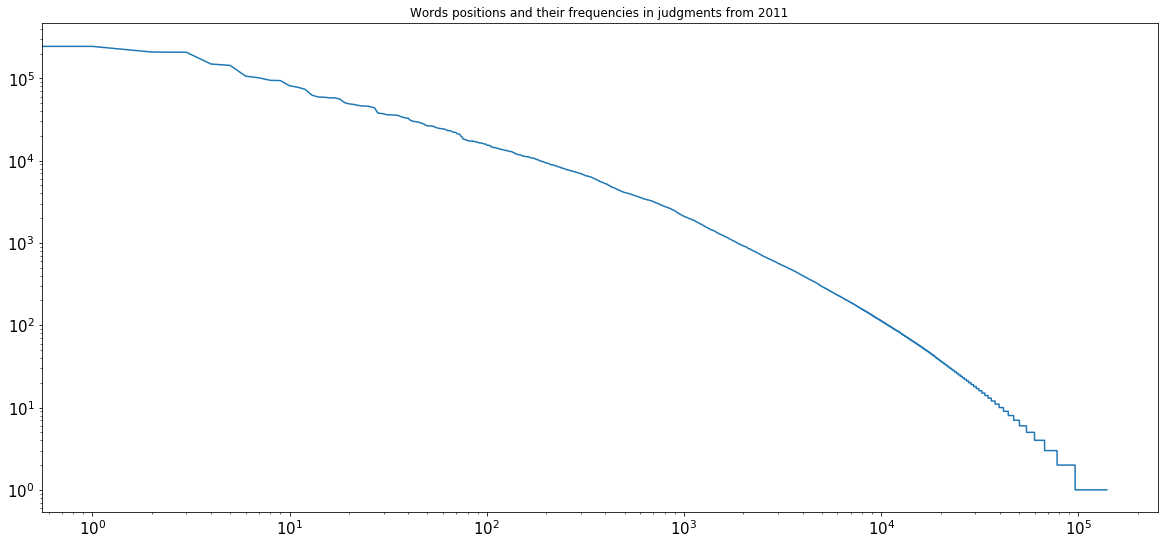

In [16]:
# all of the words
positions, word_counts = sort_and_enumerate(words_with_counts)
plt.plot(positions, word_counts)

plt.yscale('log')
plt.xscale('log')

plt.title('Words positions and their frequencies in judgments from 2011')

plt.rcParams['ytick.labelsize'] = 15 
plt.rcParams['xtick.labelsize'] = 15 

plt.rcParams["figure.figsize"] = (20, 9)

plt.show()

In [8]:
from pprint import pprint
print("Top 10 recognized Polish words: ")
pprint(sort_by_frequency(polish_words, top=10))


Top 10 recognized Polish words: 
[('na', 253290),
 ('do', 244364),
 ('nie', 208698),
 ('art', 207198),
 ('że', 149133),
 ('przez', 143483),
 ('ust', 106139),
 ('się', 101380),
 ('dnia', 94506),
 ('jest', 93871)]


In [9]:
print("Top 30 words, which were not recognized: ")
top_unrecognized_words = sort_by_frequency(not_recognized, top=30)
pprint(top_unrecognized_words)

Top 30 words, which were not recognized: 
[('pzp', 35834),
 ('siwz', 26388),
 ('sygn', 26215),
 ('zw', 11099),
 ('ssn', 6102),
 ('otk', 4902),
 ('iv', 4493),
 ('lex', 4430),
 ('zu', 4359),
 ('sa', 3852),
 ('csk', 3562),
 ('uzp', 3035),
 ('osnc', 2752),
 ('sk', 2736),
 ('czp', 2219),
 ('ppkt', 2043),
 ('niepubl', 1987),
 ('ckn', 1923),
 ('osnp', 1906),
 ('uokik', 1895),
 ('vi', 1715),
 ('uk', 1657),
 ('późn', 1647),
 ('pln', 1537),
 ('poland', 1530),
 ('zd', 1525),
 ('publ', 1473),
 ('asseco', 1205),
 ('xvii', 983),
 ('impel', 955)]


In [10]:
def levenshtein_family(word, alphabet):
    "Returns all words within levenshtein distance of 1 from the word"
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]

    deletes    = [l + r[1:] for l,r in splits if r]
    transposes = [l + r[1] + r[0] + r[2:] for l, r in splits if len(r)>1]
    replaces   = [l + letter + r[1:] for l, r in splits if r for letter in alphabet]
    inserts    = [l + letter + r for l, r in splits for letter in alphabet]

    return set(deletes + transposes + replaces + inserts)

def get_word_families(words):
    "Returns a union of levenshtein_family for each word in a word list"
    return set(edit for word in words for edit in levenshtein_family(word, alphabet))

def get_best_edit(edits):
    "Returns the best edit based on word frequencies in the original text"
    edits.sort(
        key=lambda word: polish_words.get(word, 0), 
        reverse=True,
    )
    return edits[0]  

def is_polish(word):
    return word in polish_dictionary

In [11]:
import string

alphabet = list(string.ascii_lowercase + "ąćęłóżźśń")
print("".join(alphabet))

abcdefghijklmnopqrstuvwxyząćęłóżźśń


In [12]:
def find_correction(word):
    one_step_edits = get_word_families([word])
    polish_edits = [edit for edit in one_step_edits if is_polish(edit)]

    if polish_edits:
        return get_best_edit(polish_edits)
    
    # checking words within 2 steps from the original, since 1 step didn't match
    two_step_edits = [edit for edit in get_word_families(one_step_edits)]
    polish_edits = [edit for edit in two_step_edits if is_polish(edit)]
    
    if polish_edits:
        return get_best_edit(polish_edits)
    
    # no matches within 2 steps, return no match at all
    return ""

In [13]:
for unrecognized_word, _ in top_unrecognized_words:
    correction = find_correction(unrecognized_word)
    print("{} -> {}".format(unrecognized_word.ljust(10, " "), correction))


pzp        -> pkp
siwz       -> siw
sygn       -> syn
zw         -> za
ssn        -> sn
otk        -> tk
iv         -> iż
lex        -> lek
zu         -> za
sa         -> na
csk        -> ck
uzp        -> uz
osnc       -> osób
sk         -> sp
czp        -> czy
ppkt       -> pkt
niepubl    -> nielubi
ckn        -> cen
osnp       -> osp
uokik      -> nokia
vi         -> ii
uk         -> ul
późn       -> późno
pln        -> pn
poland     -> roland
zd         -> od
publ       -> pub
asseco     -> ssąco
xvii       -> avii
impel      -> impal
